In [9]:
#Small adjoint program 16-12

from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt
from dolfin import *

#mesh = RectangleMesh(Point(0, 0), Point(100, 50), 100, 50)
#File("mesh.xml") << mesh

#mesh = Mesh("mesh.xml")
mesh = RectangleMesh(Point(0, 0), Point(1000, 500), 100, 50)

# Define finite elements instead of function spaces
velocity_el = VectorElement("CG", mesh.ufl_cell(), 2)
height_el   = FiniteElement("CG", mesh.ufl_cell(), 1)
mixed_el    = MixedElement([velocity_el, height_el])

# Now build the mixed function space
W = FunctionSpace(mesh, mixed_el)


# State
w = Function(W)       # (u, eta)
u, eta = split(w)
v, phi = TestFunctions(W)

# Physical parameters
g = Constant(9.81)
H0 = Constant(50.0)
Cd = Function(H)      # bottom drag coefficient
Cd.assign(Constant(0.0025))  # initial guess

# SWE residual
F = (inner(dot(u, nabla_grad(u)), v) * dx
     + g * inner(nabla_grad(eta), v) * dx
     + (Cd / H0) * inner(u, v) * dx
     - phi * div(H0 * u) * dx)
solve(F == 0, w)


m = Control(Cd)
J = assemble(Cd * inner(u, u)**1.5 * dx)
dJdCd = compute_gradient(J, m)

plot(dJdCd)
plt.show()

rf = ReducedFunctional(J, m)
m_opt = minimize(rf, bounds=(0.001, 0.01))

taylor_test(ReducedFunctional(J, m))

alpha = Constant(1e-4)
J = assemble(Cd * inner(u,u)**1.5 * dx + alpha * inner(grad(Cd), grad(Cd)) * dx)


TypeError: '<' not supported between instances of 'Mesh' and 'Mesh'

In [12]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# Mesh
mesh = RectangleMesh(Point(0, 0), Point(1000, 500), 100, 50)

# Mixed element
velocity_el = VectorElement("CG", mesh.ufl_cell(), 2)
height_el   = FiniteElement("CG", mesh.ufl_cell(), 1)
mixed_el    = MixedElement([velocity_el, height_el])
W = FunctionSpace(mesh, mixed_el)

# State variables
w = Function(W)
u, eta = split(w)
v, phi = TestFunctions(W)

# Parameters
g = Constant(9.81)
H0 = Constant(50.0)
Cd = Function(FunctionSpace(mesh, "CG", 1))
Cd.assign(Constant(0.0025))

# Stationary SWE-type residual (simplified)
F = (inner(dot(u, nabla_grad(u)), v) * dx
     + g * inner(nabla_grad(eta), v) * dx
     + (Cd / H0) * inner(u, v) * dx
     - phi * div(H0 * u) * dx)

J = derivative(F, w)  # Jacobian of F
problem = NonlinearVariationalProblem(F, w, bcs=None, J=J)
solver = NonlinearVariationalSolver(problem)
solver.solve()


# Objective and gradient
m = Control(Cd)
J = Cd * inner(u, u)**1.5 * dx

dJdCd = compute_gradient(J, m)

plot(dJdCd)
plt.show()


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


AttributeError: 'Form' object has no attribute 'block_variable'

In [14]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# Mesh
mesh = RectangleMesh(Point(0, 0), Point(1000, 500), 40, 20)

# Mixed element: velocity + height
velocity_el = VectorElement("CG", mesh.ufl_cell(), 2)
height_el   = FiniteElement("CG", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, MixedElement([velocity_el, height_el]))

# State and tests
w = Function(W)
u, eta = split(w)
v, phi = TestFunctions(W)

# Parameters
g = Constant(9.81)
H0 = Constant(50.0)
Cd = Function(FunctionSpace(mesh, "CG", 1))
Cd.assign(Constant(0.0025))

# Simplified steady SWE residual
F = (inner(dot(u, nabla_grad(u)), v) * dx
     + g * inner(nabla_grad(eta), v) * dx
     + (Cd / H0) * inner(u, v) * dx
     - phi * div(H0 * u) * dx)

# Nonlinear solver
J_F = derivative(F, w)
problem = NonlinearVariationalProblem(F, w, bcs=None, J=J_F)
solver = NonlinearVariationalSolver(problem)
solver.solve()

# ✅ Keep the symbolic objective
J_form = Cd * inner(u, u)**1.5 * dx
J = assemble(J_form)             # Record a scalar on the tape
m = Control(Cd)
rf = ReducedFunctional(J, m)

grad = rf.derivative()
plot(grad)
plt.show()

# Optional: Taylor test
minval, ok = rf.taylor_test(verify=True)
print("Taylor ratio:", minval)


Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 0.000e+00 (tol = 1.000e-10) r (rel) = -nan (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.


UFLValueError: Invalid type conversion: f_208 can not be converted to any UFL type.

In [19]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# Mesh
mesh = RectangleMesh(Point(0, 0), Point(1000, 500), 40, 20)

# Mixed element
velocity_el = VectorElement("CG", mesh.ufl_cell(), 2)
height_el   = FiniteElement("CG", mesh.ufl_cell(), 1)
W = FunctionSpace(mesh, MixedElement([velocity_el, height_el]))

# State fields
w = Function(W)
u, eta = split(w)
v, phi = TestFunctions(W)

# Parameters
g = Constant(9.81)
H0 = Constant(50.0)

# Cd must be a *Coefficient* in a recognised FunctionSpace so adjoint can track it
control_space = FunctionSpace(mesh, "CG", 1)
Cd = Function(control_space, name="Cd")  # give it a name = crucial for adjoint tracking
Cd.assign(Constant(0.0025))


inlet = CompiledSubDomain("near(x[0], 0.0)")
outlet = CompiledSubDomain("near(x[0], 1000.0)")
bcs = [DirichletBC(W.sub(0), Constant((0.5, 0.0)), inlet)]

# Weak form of simplified steady SWE
ν = Constant(5.0)                          # artificial viscosity term
F = (inner(dot(u, nabla_grad(u)), v) * dx
     + ν * inner(grad(u), grad(v)) * dx    # adds diffusion
     + g * inner(nabla_grad(eta), v) * dx
     + (Cd / H0) * inner(u, v) * dx
     - phi * div(H0 * u) * dx)


J_F = derivative(F, w)
problem = NonlinearVariationalProblem(F, w, bcs=bcs, J=J_F)

solver = NonlinearVariationalSolver(problem)
solver.solve()

# Define objective functional (assembled scalar recorded on tape)
J_form = Cd * inner(u, u)**1.5 * dx
J = assemble(J_form)

# Now Dolfin-adjoint can see the control
m = Control(Cd)
rf = ReducedFunctional(J, m)

grad = rf.derivative()
plot(grad)
plt.title("Gradient of J wrt Cd")
plt.show()


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.348e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.526e-06 (tol = 1.000e-10) r (rel) = 6.498e-10 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


UFLValueError: Invalid type conversion: f_421 can not be converted to any UFL type.

In [20]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# --- Mesh and spaces ---
mesh = RectangleMesh(Point(0, 0), Point(1000, 200), 60, 20)
V = FunctionSpace(mesh, "CG", 1)

# --- State and control ---
u = Function(V, name="State")
v = TestFunction(V)
Cd = Function(V, name="Cd")      # Control field
Cd.assign(Constant(0.0025))

# --- Parameters ---
H0 = Constant(50.0)
inflow = Constant(1.0)

# --- Boundary conditions (drives a non-zero flow) ---
def left(x, on_boundary):  return on_boundary and near(x[0], 0.0)
def right(x, on_boundary): return on_boundary and near(x[0], 1000.0)
bcs = [
    DirichletBC(V, inflow, left),  # fixed inflow
    DirichletBC(V, Constant(0.0), right)  # pressure outlet analog
]

# --- PDE: diffusion (momentum balance surrogate) ---
# Laplacian term + drag term = forcing
F = (inner(grad(u), grad(v)) + Cd * u * v) * dx - Constant(1.0) * v * dx

# --- Solve nonlinear (actually linear) problem ---
solve(F == 0, u, bcs)

# --- Objective functional ---
J_form = 0.5 * inner(u, u) * dx         # something to minimize or analyse
J = assemble(J_form)

# --- Reduced functional and derivative ---
m = Control(Cd)
rf = ReducedFunctional(J, m)
grad = rf.derivative()                  # << this should now work

# --- Visualize ---
plt.figure()
plot(u)
plt.title("Velocity state u")
plt.figure()
plot(grad)
plt.title("dJ/dCd")
plt.show()


AttributeError: 'Equation' object has no attribute 'form'

In [21]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# --- Mesh and spaces ---
mesh = RectangleMesh(Point(0, 0), Point(1000, 200), 60, 20)
V = FunctionSpace(mesh, "CG", 1)

# --- State and control ---
u = Function(V, name="State")
v = TestFunction(V)
Cd = Function(V, name="Cd")
Cd.assign(Constant(0.0025))

# --- Parameters ---
H0 = Constant(50.0)
inflow = Constant(1.0)

# --- Boundary conditions ---
def left(x, on_boundary):  return on_boundary and near(x[0], 0.0)
def right(x, on_boundary): return on_boundary and near(x[0], 1000.0)

bcs = [
    DirichletBC(V, inflow, left),
    DirichletBC(V, Constant(0.0), right)
]

# --- Variational forms (linear problem) ---
a = (dot(grad(u), grad(v)) + Cd * u * v) * dx
L = Constant(1.0) * v * dx

# --- Solve using a recorded solver ---
problem = LinearVariationalProblem(a, L, u, bcs)
solver = LinearVariationalSolver(problem)
solver.solve()

# --- Objective functional ---
J_form = 0.5 * pow(u, 2) * dx
J = assemble(J_form)

# --- Reduced functional & gradient ---
m = Control(Cd)
rf = ReducedFunctional(J, m)
grad = rf.derivative()

# --- Plot results ---
plt.figure()
plot(u)
plt.title("Velocity state u")
plt.figure()
plot(grad)
plt.title("Gradient dJ/dCd")
plt.show()


Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to define linear variational problem a(u, v) == L(v) for all v.
*** Reason:  Expecting the left-hand side to be a bilinear form (not rank 1).
*** Where:   This error was encountered inside LinearVariationalProblem.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  963677b7fd1d4587f22daa8744b89c6b2dbe282f
*** -------------------------------------------------------------------------


In [24]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# --- Mesh and spaces ---
mesh = RectangleMesh(Point(0, 0), Point(1000, 200), 60, 20)
V = FunctionSpace(mesh, "CG", 1)

# --- Symbolic unknowns ---
u = TrialFunction(V)
v = TestFunction(V)

# --- Parameters and control ---
Cd.rename("Cd","")
Cd = Coefficient(V).assign(Constant(0.0025))


# --- Boundary conditions ---
inflow = Constant(1.0)
def left(x, on_boundary):  return on_boundary and near(x[0], 0.0)
def right(x, on_boundary): return on_boundary and near(x[0], 1000.0)

bcs = [
    DirichletBC(V, inflow, left),
    DirichletBC(V, Constant(0.0), right)
]

# --- Bilinear and linear forms ---
a = (dot(grad(u), grad(v)) + Cd * u * v) * dx   # rank‑2 symbolic form
L = Constant(1.0) * v * dx                      # rank‑1 linear form

# --- Create a Function to store the solution ---
u_sol = Function(V, name="State")

# --- Linear solve (recorded for adjoint) ---
problem = LinearVariationalProblem(a, L, u_sol, bcs)
solver = LinearVariationalSolver(problem)
solver.solve()

# --- Objective functional ---
J_form = 0.5 * u_sol**2 * dx
J = assemble(J_form)

# --- Reduced functional & gradient ---
m = Control(Cd)
rf = ReducedFunctional(J, m)
grad = rf.derivative()

# --- Plot result ---
plt.figure()
plot(u_sol)
plt.title("Velocity state u")
plt.figure()
plot(grad)
plt.title("Gradient dJ/dCd")
plt.show()


NameError: name 'Coefficient' is not defined

In [25]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# --- Mesh and space ---
mesh = RectangleMesh(Point(0, 0), Point(1000, 200), 60, 20)
V = FunctionSpace(mesh, "CG", 1)

# --- State and control ---
u = Function(V, name="State")          # state to be solved for
v = TestFunction(V)
Cd = Function(V, name="Cd")            # control variable
Cd.assign(Constant(0.0025))

# --- Boundary conditions ---
inflow = Constant(1.0)
def left(x, on_boundary):  return on_boundary and near(x[0], 0.0)
def right(x, on_boundary): return on_boundary and near(x[0], 1000.0)

bcs = [
    DirichletBC(V, inflow, left),
    DirichletBC(V, Constant(0.0), right)
]

# --- Parameters ---
ν = Constant(5.0)   # diffusion-like term for stability
f = Constant(1.0)   # uniform forcing

# --- Nonlinear residual (depends on Cd) ---
F = (ν*inner(grad(u), grad(v)) + Cd*u**2*v - f*v) * dx

# --- Solve nonlinear PDE explicitly recorded for adjoint ---
J_F = derivative(F, u)
problem = NonlinearVariationalProblem(F, u, bcs=bcs, J=J_F)
solver = NonlinearVariationalSolver(problem)
solver.solve()

# --- Objective functional ---
J_form = 0.5 * u**2 * dx
J = assemble(J_form)

# --- Reduced functional and gradient ---
m = Control(Cd)
rf = ReducedFunctional(J, m)
grad = rf.derivative()

# --- Plot results ---
plt.figure()
plot(u)
plt.title("State field u")
plt.figure()
plot(grad)
plt.title("Gradient dJ/dCd")
plt.show()



Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.655e+03 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 5.675e+09 (tol = 1.000e-10) r (rel) = 1.003e+06 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.419e+09 (tol = 1.000e-10) r (rel) = 2.509e+05 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 3.547e+08 (tol = 1.000e-10) r (rel) = 6.272e+04 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 8.866e+07 (tol = 1.000e-10) r (rel) = 1.568e+04 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 2.216e+07 (tol = 1.000e-10) r (rel) = 3.920e+03 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 5.540e+06 (tol = 1.000e-10) r (rel) = 9.797e+02 (tol = 1.000e-09)
  Newton iteration 7: r (abs) = 1.384e+06 (tol = 1.000e-10) r (rel) = 2.447e+02 (tol = 1.000e-09)
  Newton iteration 8: r (abs) = 3.448e+05 (to

UFLValueError: Invalid type conversion: f_580 can not be converted to any UFL type.

Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 4.611e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.919e-05 (tol = 1.000e-10) r (rel) = 8.499e-07 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 3.106e-14 (tol = 1.000e-10) r (rel) = 6.735e-16 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


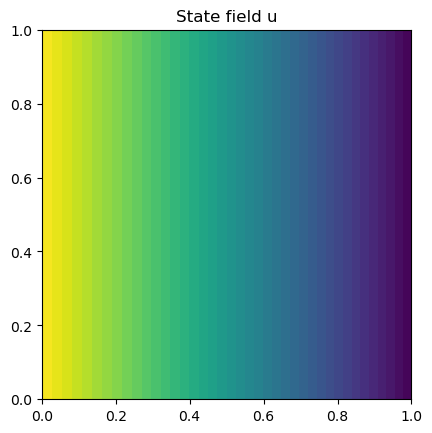

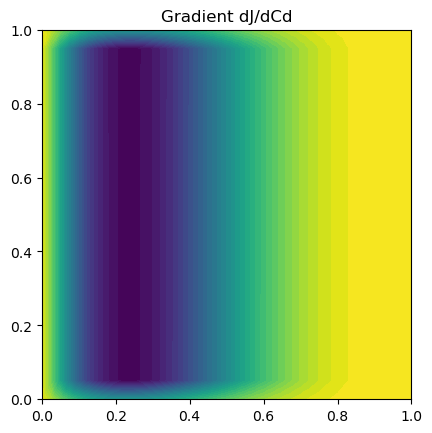

In [4]:
from fenics import *
from dolfin_adjoint import *
import matplotlib.pyplot as plt

# --- Mesh and spaces ---
mesh = UnitSquareMesh(40, 20)
V_state = FunctionSpace(mesh, "CG", 1)
V_ctrl  = FunctionSpace(mesh, "CG", 1)

# --- State and control ---
u = Function(V_state, name="State")
v = TestFunction(V_state)
Cd = Function(V_ctrl, name="Cd")
Cd.assign(Constant(0.0025))

# --- Boundary conditions ---
inflow = Constant(1.0)
def left(x, on_boundary):  return near(x[0], 0.0) and on_boundary
def right(x, on_boundary): return near(x[0], 1.0) and on_boundary
bcs = [DirichletBC(V_state, inflow, left),
       DirichletBC(V_state, Constant(0.0), right)]

# --- Parameters and forcing ---
nu = Constant(5.0)   # artificial viscosity
f  = Constant(1.0)

# --- Nonlinear residual explicitly dependent on Cd ---
F = (nu*dot(grad(u), grad(v)) + Cd*u**2*v - f*v)*dx
J_F = derivative(F, u)

problem = NonlinearVariationalProblem(F, u, bcs=bcs, J=J_F)
solver  = NonlinearVariationalSolver(problem)
solver.solve()

# --- Objective functional (scalar) ---
J_form = 0.5*u**2*dx
J = assemble(J_form)

# --- Reduced functional and derivative ---
m = Control(Cd)
rf = ReducedFunctional(J, m)
grad = rf.derivative()           # <-- works on this setup

# --- Plot to verify ---
plt.figure(); plot(u);     plt.title("State field u")
plt.figure(); plot(grad);  plt.title("Gradient dJ/dCd")
plt.show()


In [5]:
import dolfin; import dolfin_adjoint; print(dolfin.__version__)

2019.1.0


In [3]:
from fenics import *
from dolfin_adjoint import *

# --- Mesh and spaces ---
mesh = UnitIntervalMesh(40)
V = FunctionSpace(mesh, "CG", 1)
Vc = FunctionSpace(mesh, "CG", 1)

# --- Control and state ---
m  = Function(Vc, name="Control")
m.assign(Constant(1.0))
u  = Function(V,  name="State")
v  = TestFunction(V)

# --- Forward problem ---
F = (dot(grad(u), grad(v)) + m*u*v - v)*dx
J_F = derivative(F, u)
problem = NonlinearVariationalProblem(F, u, J=J_F)
solver  = NonlinearVariationalSolver(problem)
solver.solve()

# --- Objective functional ---
J = assemble((u - 1.0)**2 * dx)

# --- Adjoint & gradient ---
control = Control(m)
rf = ReducedFunctional(J, control)
grad = rf.derivative()

# --- Sanity check ---
File("u.pvd") << u
File("grad.pvd") << grad

print("‖grad‖ =", norm(grad))


Solving nonlinear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Newton iteration 0: r (abs) = 1.571e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.550e-14 (tol = 1.000e-10) r (rel) = 4.169e-13 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
‖grad‖ = 6.1031243454057085e-15


In [2]:
from fenics import *
from dolfin_adjoint import *

mesh = UnitIntervalMesh(10)
V = FunctionSpace(mesh, "CG", 1)
m = Function(V, name="Control"); m.assign(Constant(1.0))
u = Function(V, name="State"); v = TestFunction(V)
F = (dot(grad(u), grad(v)) + m*u*v - v)*dx
solve(F == 0, u)
J = assemble((u - 1)**2 * dx)
rf = ReducedFunctional(J, Control(m))
print("Gradient computed OK:", rf.derivative())


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.082e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 8.673e-15 (tol = 1.000e-10) r (rel) = 2.814e-14 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Gradient computed OK: f_173


In [30]:
python -c "import dolfin, ufl, dolfin_adjoint; print('dolfin:', dolfin.__version__, 'ufl:', ufl.__version__, 'adjoint:', dolfin_adjoint.__version__)"


SyntaxError: invalid syntax (484938564.py, line 1)

In [1]:
from fenics import *
from dolfin_adjoint import *

mesh = UnitIntervalMesh(10)
V = FunctionSpace(mesh, "CG", 1)
m = Function(V, name="Control"); m.assign(Constant(1.0))
u = Function(V, name="State"); v = TestFunction(V)
F = (dot(grad(u), grad(v)) + m*u*v - v)*dx
solve(F == 0, u)
J = assemble((u - 1)**2 * dx)
rf = ReducedFunctional(J, Control(m))
print("Gradient computed OK:", rf.derivative())


/home/zabreedveld/miniconda3/envs/fenicsproject/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.082e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 8.673e-15 (tol = 1.000e-10) r (rel) = 2.814e-14 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Gradient computed OK: f_85
